In [ ]:
import re
import string
import gc
import os
import shutil
from datetime import datetime
import time
from pathlib import Path
import random
import joblib

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.multioutput import MultiOutputRegressor

import tensorflow as tf
import torch
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, TextClassificationPipeline, AutoConfig, get_cosine_schedule_with_warmup
from datasets import Dataset, DatasetDict

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from lightgbm import LGBMRegressor, Booster

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [ ]:
print(torch.__version__)
sns.set_style('darkgrid')

1.12.1+cu113


In [ ]:
def on_gpu(f):
    def wrapper():
        if torch.cuda.is_available():
            return f()
        else:
            print('cuda unavailable')
    return wrapper

In [ ]:
if torch.cuda.is_available():
    from pynvml import *
    from numba import cuda

@on_gpu
def print_gpu_utilization():
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    except Exception as e:
        print(e)

@on_gpu
def free_gpu_cache():
    print("Initial GPU Usage")
    print_gpu_utilization()                          

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization()
    
def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [ ]:
print_gpu_utilization()
free_gpu_cache()

GPU memory occupied: 3 MB.
Initial GPU Usage
GPU memory occupied: 3 MB.
GPU Usage after emptying the cache
GPU memory occupied: 3 MB.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
BASIC_PATH = 'gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning'

In [ ]:
train_data = pd.read_csv('./train.csv')
aug_data = pd.read_csv(f'{BASIC_PATH}/data/aug_data.csv')
train_data

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


In [ ]:
TARGET_VARIABLES = list(train_data.columns[2:])
TARGET_VARIABLES

['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [ ]:
STOPWORDS = set(stopwords.words('english'))
ps = PorterStemmer()

def remove_stopwords(text):
    return ' '.join([word for word in str(text).split() if word not in STOPWORDS])

def data_preprocess(text, remove_punctuation=False):
    if remove_punctuation: 
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = text.strip()
    text = re.sub(r'\n', '', text)
    text = text.lower()
    text = ps.stem(text)
    text = remove_stopwords(text)
    return text

In [ ]:
X, y = train_data['full_text'], pd.concat([train_data['text_id'], train_data.iloc[:, 2:]], axis=1)
X

0       I think that students would benefit from learn...
1       When a problem is a change you have to let it ...
2       Dear, Principal\n\nIf u change the school poli...
3       The best time in life is when you become yours...
4       Small act of kindness can impact in other peop...
                              ...                        
3906    I believe using cellphones in class for educat...
3907    Working alone, students do not have to argue w...
3908    "A problem is a chance for you to do your best...
3909    Many people disagree with Albert Schweitzer's ...
3910    Do you think that failure is the main thing fo...
Name: full_text, Length: 3911, dtype: object

In [ ]:
y

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...
3906,FFD29828A873,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,4.0,4.5,4.5,4.0,4.5,4.5


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
def to_train_test_splits(X_train, X_test, y_train, y_test):
    train_split = pd.concat([X_train, y_train], axis=1)
    test_split = pd.concat([X_test, y_test], axis=1)
    return train_split, test_split

In [ ]:
MODEL_NAME = 'distilbert-base-uncased' # distilbert-base-uncased, microsoft/deberta-v3-base

In [ ]:
def get_tokenizer():
    if os.path.exists(f'{BASIC_PATH}/tokenizers/{MODEL_NAME}'):
        return f'{BASIC_PATH}/tokenizers/{MODEL_NAME}'
    return MODEL_NAME

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(get_tokenizer())

In [ ]:
try:
    tokenizer.save_pretrained(f'{BASIC_PATH}/tokenizers/{MODEL_NAME}')
except Exception as e:
    print(e)

In [ ]:
def tokenization(example):
    return tokenizer(example['full_text'], 
                    max_length=512, 
                    padding='max_length', 
                    truncation=True, 
                    add_special_tokens=True,
                    return_tensors='pt')

def tokenize(example):
    return tokenizer(example, 
                    max_length=512, 
                    padding='max_length', 
                    truncation=True, 
                    add_special_tokens=True,
                    return_tensors='pt')
    
def collate(inputs):
    mask_len = int(inputs['attention_mask'].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

In [ ]:
class FeedbackDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = df[TARGET_VARIABLES].reset_index(drop=True)
        self.texts = df[['full_text']].reset_index(drop=True)

    def labels(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels.loc[idx].values).astype(float)

    def get_batch_texts(self, idx):
        if type(idx) == int:
            idx = [idx]
        return tokenize(list(np.array(self.texts.loc[idx].values)[:, 0]))

    def __getitem__(self, idx):
        return self.get_batch_texts(idx), self.get_batch_labels(idx)

class PredictDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.texts = df[['full_text']].reset_index(drop=True)

    def __len__(self):
        return len(self.texts)

    def get_batch_texts(self, idx):
        if type(idx) == int:
            idx = [idx]
        return tokenize(list(np.array(self.texts.loc[idx].values)[:, 0]))

    def __getitem__(self, idx):
        return self.get_batch_texts(idx)

In [ ]:
class MeanPooling(torch.nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(torch.nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim = 1)
        return max_embeddings
    
class MinPooling(torch.nn.Module):
    def __init__(self):
        super(MinPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = 1e-4
        min_embeddings, _ = torch.min(embeddings, dim = 1)
        return min_embeddings

In [ ]:
class FeedbackModel(torch.nn.Module):

    def __init__(self, dropout=0.1, pooling='mean'):

        super(FeedbackModel, self).__init__()
        
        self.config = AutoConfig.from_pretrained(MODEL_NAME, output_hidden_states=True)

        self.base = AutoModel.from_pretrained(MODEL_NAME, config=self.config)

        if pooling == 'mean':
            self.pooler = MeanPooling()
        elif pooling == 'max':
            self.pooler = MaxPooling()
        elif pooling == 'min':
            self.pooler = MinPooling()
        
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(768, 256)
        self.final_gelu = torch.nn.GELU()
        self.out = torch.nn.Linear(256,6)
    
    def features(self, input_ids, attention_mask):
        input_ids = input_ids.squeeze(1)
        attention_mask = attention_mask.squeeze(1)
        
        out = self.base(input_ids=input_ids,attention_mask=attention_mask,
                         output_hidden_states=True)
        last_hidden_states = out[0]
        x = self.pooler(last_hidden_states, attention_mask)
        x = self.dropout(x)
        x = self.linear(x)
        features = self.final_gelu(x)
        return features

    def forward(self, input_ids, attention_mask):
        features = self.features(input_ids, attention_mask)
        final_layer = self.out(features)
        return final_layer

In [ ]:
def MCRMSE(actual, predicted):
    squared_diff = (actual - predicted)**2
    sqrt_mean = np.sqrt(np.mean(squared_diff, axis=0))
    return np.mean(sqrt_mean)

In [ ]:
def is_trained():
    chckpt_path = f'{BASIC_PATH}/models/{MODEL_NAME}'
    if os.path.exists(chckpt_path) and os.path.exists(f'{chckpt_path}/trained'):
        return True
    return False

def retrain():
    shutil.rmtree(f'{BASIC_PATH}/models/{MODEL_NAME}', ignore_errors=True)

In [ ]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

def train(f):
    def wrapper(model, *args, **kwargs):
        model.train()
        return f(model, *args, **kwargs)
    return wrapper

In [ ]:
@train
def train_step(model, criterion, optimizer, scaler, scheduler,  step, train_input, train_labels, config):
    step_loss = 0

    train_labels = train_labels.to(device).float()
    mask = train_input['attention_mask'].to(device)
    input_id = train_input['input_ids'].to(device)

    with torch.cuda.amp.autocast(enabled=True):
        output = model(input_id, mask)
        
        batch_loss = criterion(output, train_labels)
    
    if config['gradient_accumulation_steps'] > 1:
        batch_loss = batch_loss / config['gradient_accumulation_steps']

    step_loss += batch_loss.item()

    if config['fp16']:
        scaler.scale(batch_loss).backward()
    else:
        batch_loss.backward()

    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])

    if (step + 1) % config['gradient_accumulation_steps'] == 0:
        if config['fp16']:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()

        scheduler.step()
        optimizer.zero_grad()

    return step_loss

@eval
def val_step(model, criterion, val_input, val_label):
    step_loss = 0
    step_mcrmse = 0

    val_label = val_label.to(device)
    mask = val_input['attention_mask'].to(device)
    input_id = val_input['input_ids'].to(device)

    output = model(input_id, mask)

    batch_loss = criterion(output, val_label)
    step_loss += batch_loss.item()
    step_mcrmse += MCRMSE(val_label.to('cpu').numpy(), output.to('cpu').numpy())
    return step_loss, step_mcrmse

In [ ]:
def training(model, train_data, val_data, config, do_val=False):
    model.train()

    model = model.to(device)

    scaler =  torch.cuda.amp.GradScaler(enabled=config['apex'])

    if do_val:
        val = FeedbackDataset(val_data)
    train = FeedbackDataset(train_data)

    criterion = torch.nn.SmoothL1Loss(reduction='mean').to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['lr'], 
        eps=config['eps'],
        weight_decay=config['weight_decay']
    )

    num_train_steps = int(len(train_data) / config['batch_size'] * config['epochs'])
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=config['num_warmup_steps'], 
        num_training_steps=num_train_steps, 
        num_cycles=config['num_cycles'],
    )

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=config['batch_size'], shuffle=True)
    if do_val:
        val_dataloader = torch.utils.data.DataLoader(val, batch_size=config['batch_size'])

    results = {
        'train_losses': [],
        'val_losses': [],
        'val_mcrmse': [],
    }

    for epoch_num in range(config['epochs']):

        total_loss_train = 0

        for step, (train_input, train_labels) in enumerate(tqdm(train_dataloader)):
            train_input = collate(train_input)
            total_loss_train += train_step(model, criterion, optimizer, scaler, scheduler,  step, train_input, train_labels, config)

        if do_val:
            total_loss_val = 0
            total_mcrmse_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:
                    step_loss, step_mcrmse = val_step(model, criterion, val_input, val_label)
                    total_loss_val += step_loss
                    total_mcrmse_val += step_mcrmse
        
        train_steps = len(train_data) / config['batch_size']

        if do_val:
            val_steps = len(val_data) / config['batch_size']
        
        results['train_losses'].append(total_loss_train / train_steps)
        if do_val:
            results['val_losses'].append(total_loss_val / val_steps)
            results['val_mcrmse'].append(total_mcrmse_val / val_steps)

        print(f'Epoch: {epoch_num + 1} | Train Loss: {total_loss_train / train_steps: .3f}', end=' ')
        if do_val:
            print(f'| Val Loss: {total_loss_val / val_steps: .3f} | Val MCRMSE: {total_mcrmse_val / val_steps: .3f}')
    return results

In [ ]:
def save_model_tmp(model, name):
    print('Saving model to tmp location...')
    try:
        Path(f'{BASIC_PATH}/models/{MODEL_NAME}/tmp').mkdir(parents=True, exist_ok=True)
        torch.save(model.cpu().state_dict(), f'{BASIC_PATH}/models/{MODEL_NAME}/tmp/{name}')
    except Exception as e:
        print(e)

def save_model(fold, model, name=''):
    print('Saving model...')
    try:
        Path(f'{BASIC_PATH}/models/{MODEL_NAME}').mkdir(parents=True, exist_ok=True)
        if fold == 0:
            torch.save(model.cpu().state_dict(), f'{BASIC_PATH}/models/{MODEL_NAME}/{name}')
        else:
            torch.save(model.cpu().state_dict(), f'{BASIC_PATH}/models/{MODEL_NAME}/fold_{fold}')
    except Exception as e:
        print(e)

def plot_results(fold, results):
    epochs_x = list(range(1, len(results['train_losses']) + 1))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    ax1.plot(epochs_x, results['train_losses'], color='y')
    ax1.plot(epochs_x, results['val_losses'], color='b')
    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')

    ax2.plot(epochs_x, results['val_mcrmse'])
    ax2.set_title('MCRMSE')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('mcrmse')

    plt.title(f'Fold: {fold}')
    
    plt.show()

def kfold_train_features(train_split, test_split, config, plot=False, save_folds=True):
    kf = MultilabelStratifiedKFold(n_splits=config['n_splits'], shuffle=True, random_state=42)
    
    kfold_results = []
    kfold_preds = []
    kfold_features = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X=np.zeros(train_split.shape[0]), y=train_split)):
        print(f"\n{'='*40} Fold: {fold + 1} {'='*40}")
        
        train_data = train_split.loc[train_idx]
        val_data = train_split.loc[val_idx]

        model = get_model(retrain=True)

        results = training(model, train_data, val_data, config, do_val=True)
        kfold_results.append(results)
        
        preds, feats = predict(model, test_split, config)
        kfold_preds.append(preds)
        kfold_features.append(feats)

        # plot stats from fold training
        if plot:
            plot_results(fold + 1, kfold_results[-1])
        
        if save_folds:
            save_model(fold + 1, model)

        # cleanup after one fold
        del model
        gc.collect()
        free_gpu_cache()
        
    return kfold_results, kfold_preds, kfold_features

In [ ]:
@eval
def evaluate(model, test_data, config):
    model = model.to(device)

    test = FeedbackDataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=config['batch_size'])

    total_score = 0
    with torch.no_grad():
        for test_input, test_labels in tqdm(test_dataloader):
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].to(device)

            output = model(input_id, mask)

            total_score += MCRMSE(test_labels.to('cpu').numpy(), output.to('cpu').numpy())
    test_steps = len(test_data) / config['batch_size']
    return total_score / test_steps

In [ ]:
@eval
def predict(model, test_data, config):
    model = model.to(device)

    test = PredictDataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=config['batch_size'])

    predictions = []
    features = []
    with torch.no_grad():
        for test_input in tqdm(test_dataloader):
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].to(device)

            out_features = model.features(input_id, mask)
            output = model.out(out_features)
            predictions.append(output.cpu().numpy())
            features.append(out_features.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(features)

In [ ]:
def get_model(fold=0, retrain=False, **kwargs):
    model = FeedbackModel(**kwargs)
    if retrain:
        return model
    if is_trained():
        model = FeedbackModel(**kwargs)
        if fold == 0:
            model.load_state_dict(torch.load(f'{BASIC_PATH}/models/{MODEL_NAME}/config_{kwargs["pooling"]}'))
        else:
            model.load_state_dict(torch.load(f'{BASIC_PATH}/models/{MODEL_NAME}/fold_{fold}'))
        return model
    return model

In [ ]:
def train_confidence(train_split, val_split, model_params, config, plot=False):
    kf = MultilabelStratifiedKFold(n_splits=config['n_splits'], shuffle=True, random_state=42)

    # optimizing confidence
    best_score = np.inf
    best_split = None
    best_split_data = None
    for split, (train_idx, _) in enumerate(kf.split(X=np.zeros(train_split.shape[0]), y=train_split)):
        print(f"\n{'-'*40} Unlabelled split: {split + 1} {'-'*40}")

        train_data = train_split.iloc[train_idx]

        model = get_model(retrain=False, **model_params)

        results = training(model, train_data, val_split, config, do_val=True)
        
        if plot:
            plot_results(0, results)
        
        score = evaluate(model, val_split, {**config, 'batch_size': 2 * config['batch_size']})
        print('----> MCRMSE:', score)
        if score < best_score:
            # predicted_data.loc[train_idx]
            best_split = split
            best_split_data = train_data

        save_model_tmp(model, name=f'split_{split}_config_{model_params["pooling"]}')

        # cleanup after one split
        del model
        gc.collect()
        free_gpu_cache()

    best_name = f'split_{best_split}_config_{model_params["pooling"]}'
    shutil.move(f'{BASIC_PATH}/models/{MODEL_NAME}/tmp/{best_name}', f'{BASIC_PATH}/models/{MODEL_NAME}/config_{model_params["pooling"]}')
    shutil.rmtree(f'{BASIC_PATH}/models/{MODEL_NAME}/tmp', ignore_errors=True)
    return best_split_data

def train_coreg(train_labelled, train_unlabelled, val_data, config, plot=False):
    # data that we've not trained yet (e.g. 20% left after main training)
    L = [train_labelled.copy(), train_labelled.copy()]

    part_50 = train_unlabelled.sample(frac = 0.5, random_state=42)
    U = [part_50.copy(), train_unlabelled.drop(part_50.index)]
    predicted_U = [None, None]

    models_params = [{'pooling': 'mean'}, {'pooling': 'max'}]

    # while we have what to train on
    iter = 0
    while (U[0].shape[0] > 500 and U[1].shape[0] > 500) and iter < config['n_iters']:
        iter += 1
        print('U1 size', U[0].shape[0], 'U2 size', U[1].shape[0])
        print('--> Cross Predicting models...')
        for i, mp in enumerate(models_params):
            print('--> Predicting using model:', mp)
            model = get_model(retrain=False, **mp)

            predicted_U[(i + 1) % 2], _ = predict(model, U[(i + 1) % 2], {**config, 'batch_size': 2 * config['batch_size']})
        
        del model
        free_gpu_cache()
        gc.collect()
        
        print('--> Training condifidence models...')
        for i, mp in enumerate(models_params):
            print('--> Traning confidence using model:', mp)
            model = get_model(retrain=False, **mp)

            predicted_U_df = pd.concat([U[i], pd.DataFrame(predicted_U[i], index=U[i].index, columns=TARGET_VARIABLES)], axis=1)
            best_split_data = train_confidence(predicted_U_df, L[i], mp, config, plot=plot)
            U[i] = U[i].drop(best_split_data.index)
        print('\n\n\n')
    
    print('--> Training model on the final part of the data...')
    for i, mp in enumerate(models_params):
        model = get_model(retrain=False, **mp)
        results = training(model, train_labelled, val_data, config, do_val=True)

        if plot:
            plot_results(0, results)

        save_model(0, model, f'config_{mp["pooling"]}')
    return L

In [ ]:
def kfold_predict_features(test_split, config):
    kfold_features = []
    kfold_predictions = []
    for fold in range(1, config['n_splits'] + 1):
        print(f"\n{'='*40} Fold: {fold} {'='*40}")

        model = get_model(fold, retrain=False)

        preds, feats = predict(model, test_split, config)
        kfold_features.append(feats)
        kfold_predictions.append(preds)

        # cleanup after one fold
        del model
        gc.collect()
        free_gpu_cache()
        
    return np.array(kfold_predictions).mean(axis=0), np.array(kfold_features).mean(axis=0)

In [ ]:
train_split, test_split = to_train_test_splits(X_train, X_test, y_train, y_test)

In [ ]:
config = {
    'epochs': 5,
    'fp16': True,
    'gradient_accumulation_steps': 1,
    'max_grad_norm': 1000, 
    'batch_size': 32,
    'apex': True,
    # optimizer
    'lr': 2e-5,
    'min_lr': 1e-6,
    'weight_decay': 0.01,
    'eps': 1e-6,
    # scheduler
    'T_0': 500,
    'T_max': 500,
    'num_cycles': 0.5,
    'num_warmup_steps': 0,
    # kfold:
    'n_splits': 4,
    'n_iters': 5,
}

In [ ]:
RETRAIN = True

In [ ]:
train_split_80 = train_split.sample(frac=0.8, random_state=42)
val_split_20 = train_split.drop(train_split_80.index)

Training mean pooling model...


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  1.496 | Val Loss:  0.617 | Val MCRMSE:  1.213


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.357 | Val Loss:  0.210 | Val MCRMSE:  0.666


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 3 | Train Loss:  0.195 | Val Loss:  0.178 | Val MCRMSE:  0.610


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 4 | Train Loss:  0.160 | Val Loss:  0.161 | Val MCRMSE:  0.578


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 5 | Train Loss:  0.147 | Val Loss:  0.149 | Val MCRMSE:  0.555


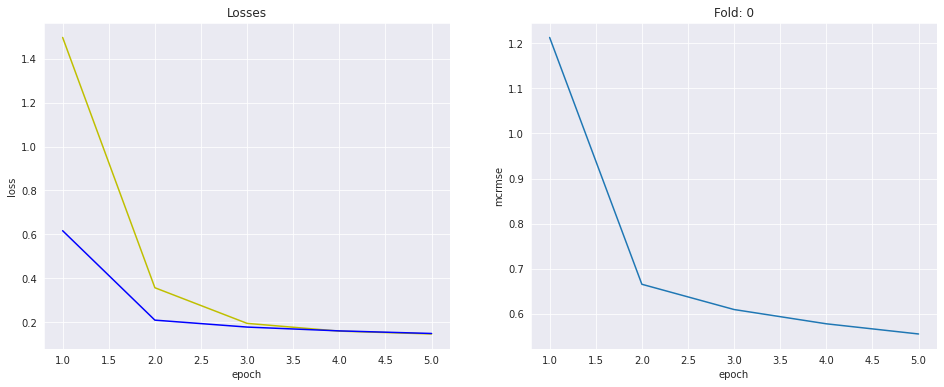

Saving model...


In [ ]:
if RETRAIN:
    print('Training mean pooling model...')

    model = get_model(0, RETRAIN, **{'pooling': 'mean'})

    train_split_80 = train_split.sample(frac=0.8, random_state=42)
    results = training(model, train_split_80, val_split_20, config, do_val=True)

    plot_results(0, results)

    save_model(0, model, name='config_mean')

In [ ]:
score = evaluate(model, test_split, {**config, 'batch_size': 2 * config['batch_size']})
score

  0%|          | 0/21 [00:00<?, ?it/s]

0.5606082044721926

In [ ]:
free_gpu_cache()
gc.collect()

Initial GPU Usage
GPU memory occupied: 11554 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1466 MB.


5208

Training max pooling model...


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  1.251 | Val Loss:  0.192 | Val MCRMSE:  0.635


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.154 | Val Loss:  0.127 | Val MCRMSE:  0.513


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 3 | Train Loss:  0.132 | Val Loss:  0.134 | Val MCRMSE:  0.525


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 4 | Train Loss:  0.123 | Val Loss:  0.126 | Val MCRMSE:  0.510


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 5 | Train Loss:  0.119 | Val Loss:  0.127 | Val MCRMSE:  0.511


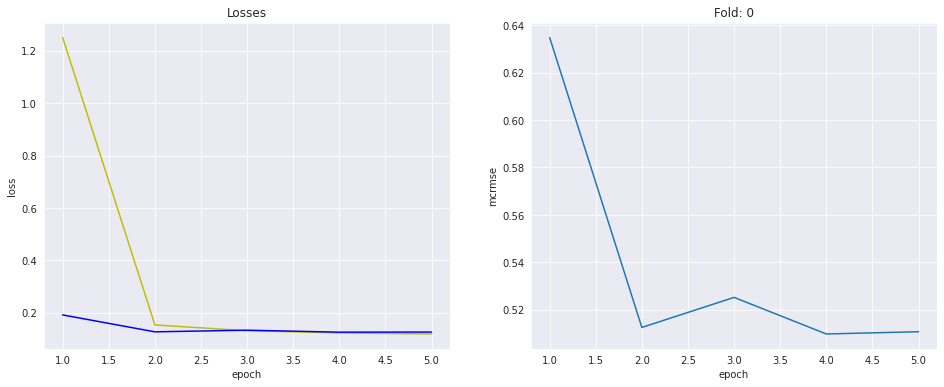

Saving model...


In [ ]:
if RETRAIN:
    print('Training max pooling model...')

    model = get_model(0, RETRAIN, **{'pooling': 'max'})

    train_split_80 = train_split.sample(frac=0.8, random_state=42)
    results = training(model, train_split_80, val_split_20, config, do_val=True)

    plot_results(0, results)

    save_model(0, model, name='config_max')

In [ ]:
score = evaluate(model, test_split, {**config, 'batch_size': 2 * config['batch_size']})
score

  0%|          | 0/21 [00:00<?, ?it/s]

0.516632015245665

In [ ]:
free_gpu_cache()
gc.collect()

Initial GPU Usage
GPU memory occupied: 11644 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.


5192

In [ ]:
config['epochs'] = 2

Training model
U1 size 2938 U2 size 2937
--> Cross Predicting models...
--> Predicting using model: {'pooling': 'mean'}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/46 [00:00<?, ?it/s]

--> Predicting using model: {'pooling': 'max'}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/46 [00:00<?, ?it/s]

Initial GPU Usage
GPU memory occupied: 4242 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.
--> Training condifidence models...
--> Traning confidence using model: {'pooling': 'mean'}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T


---------------------------------------- Unlabelled split: 1 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.028 | Val Loss:  0.209 | Val MCRMSE:  0.664


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.010 | Val Loss:  0.188 | Val MCRMSE:  0.627


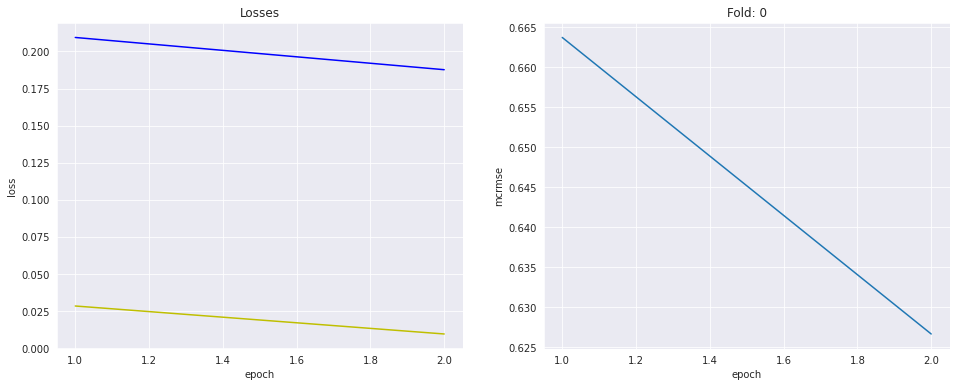

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.6725554340417351
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12108 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.

---------------------------------------- Unlabelled split: 2 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.023 | Val Loss:  0.205 | Val MCRMSE:  0.657


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.010 | Val Loss:  0.192 | Val MCRMSE:  0.635


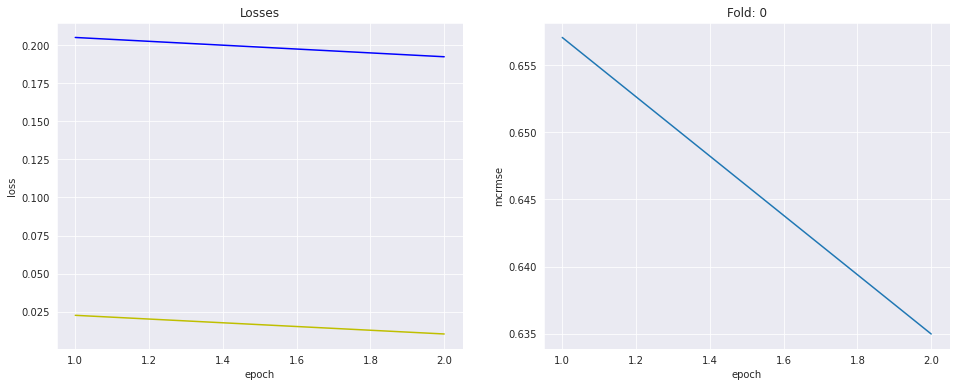

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.681875466673946
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12108 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.

---------------------------------------- Unlabelled split: 3 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.023 | Val Loss:  0.200 | Val MCRMSE:  0.647


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.009 | Val Loss:  0.189 | Val MCRMSE:  0.630


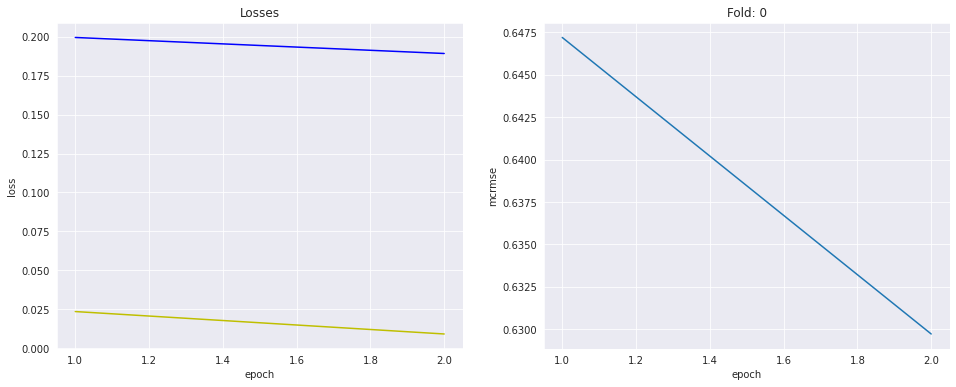

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.6758297943559401
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12108 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.

---------------------------------------- Unlabelled split: 4 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.024 | Val Loss:  0.199 | Val MCRMSE:  0.647


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.010 | Val Loss:  0.192 | Val MCRMSE:  0.634


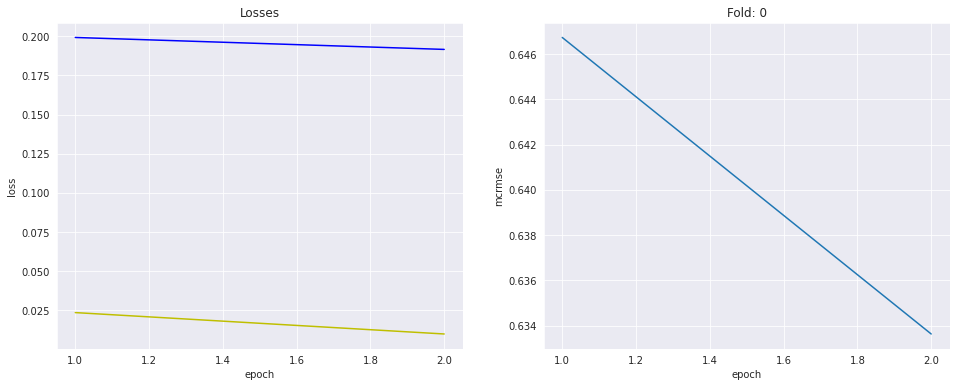

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.6803276909665826
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12108 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.
--> Traning confidence using model: {'pooling': 'max'}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T


---------------------------------------- Unlabelled split: 1 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.014 | Val Loss:  0.152 | Val MCRMSE:  0.560


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.010 | Val Loss:  0.143 | Val MCRMSE:  0.544


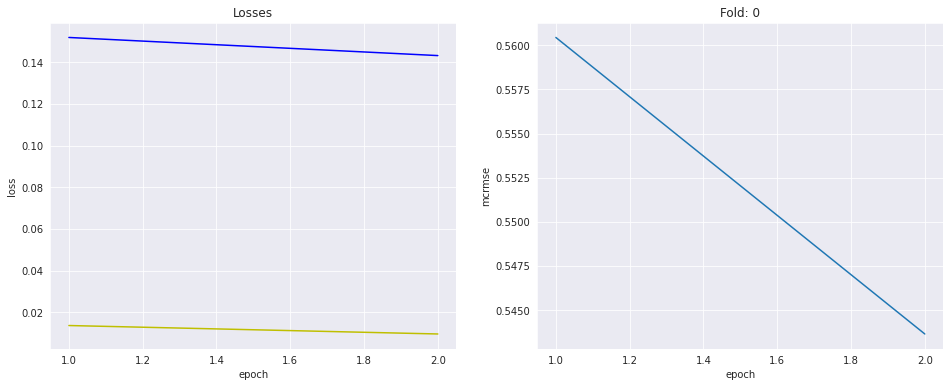

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.5812898517002224
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12106 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.

---------------------------------------- Unlabelled split: 2 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.014 | Val Loss:  0.143 | Val MCRMSE:  0.543


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.009 | Val Loss:  0.144 | Val MCRMSE:  0.546


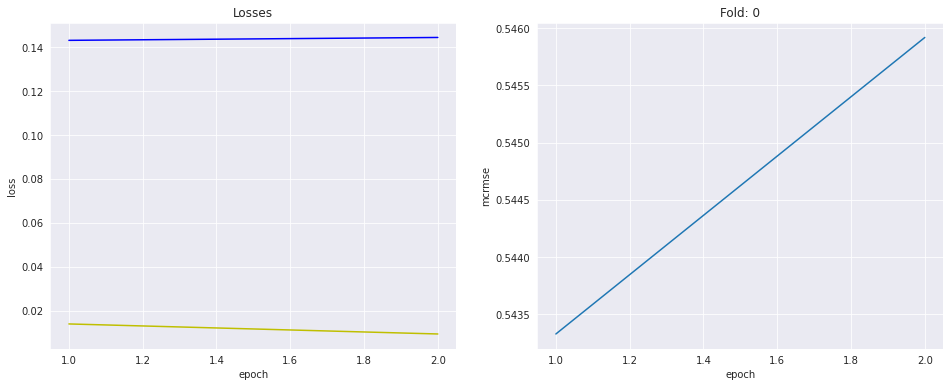

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.5840076478700751
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12106 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.

---------------------------------------- Unlabelled split: 3 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.018 | Val Loss:  0.149 | Val MCRMSE:  0.555


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.010 | Val Loss:  0.143 | Val MCRMSE:  0.542


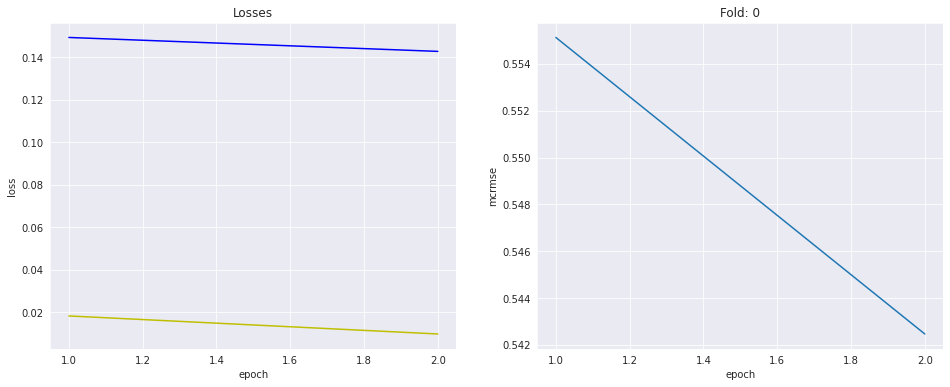

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.5801943554279064
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12106 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.

---------------------------------------- Unlabelled split: 4 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.015 | Val Loss:  0.146 | Val MCRMSE:  0.548


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.009 | Val Loss:  0.140 | Val MCRMSE:  0.537


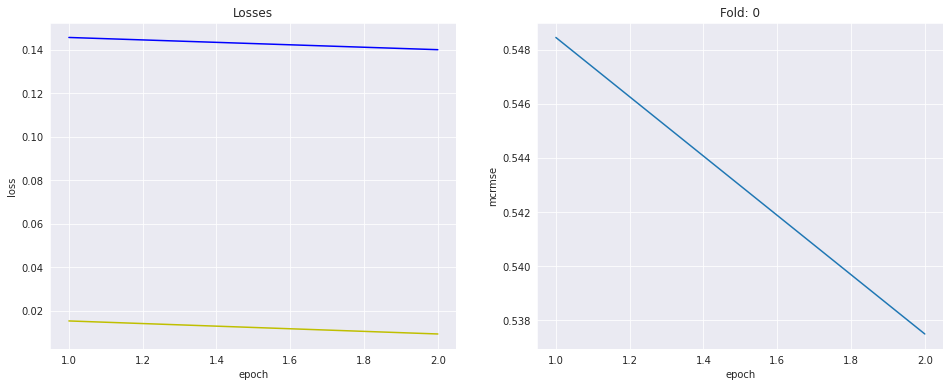

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.5745602836877077
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12106 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.




U1 size 735 U2 size 734
--> Cross Predicting models...
--> Predicting using model: {'pooling': 'mean'}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/12 [00:00<?, ?it/s]

--> Predicting using model: {'pooling': 'max'}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/12 [00:00<?, ?it/s]

Initial GPU Usage
GPU memory occupied: 4242 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.
--> Training condifidence models...
--> Traning confidence using model: {'pooling': 'mean'}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T


---------------------------------------- Unlabelled split: 1 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.063 | Val Loss:  0.213 | Val MCRMSE:  0.668


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.012 | Val Loss:  0.172 | Val MCRMSE:  0.597


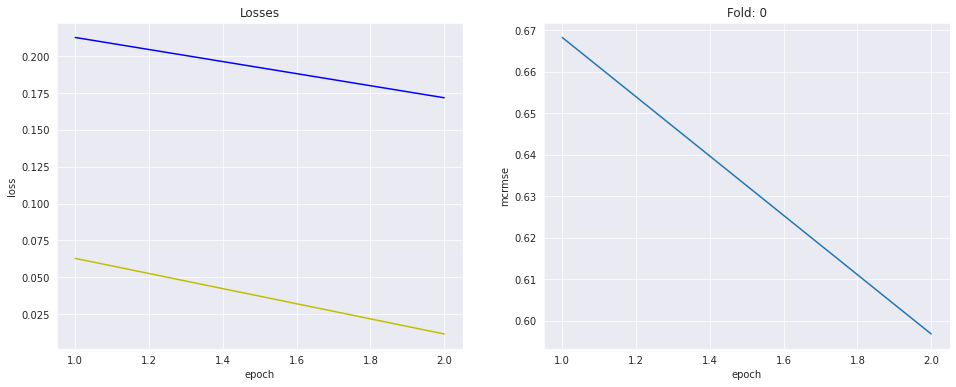

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.6407746804335692
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12108 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.

---------------------------------------- Unlabelled split: 2 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.027 | Val Loss:  0.164 | Val MCRMSE:  0.583


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.007 | Val Loss:  0.161 | Val MCRMSE:  0.577


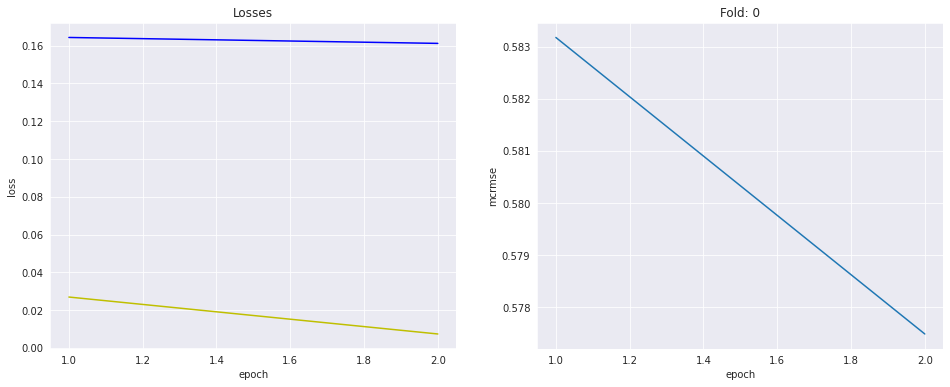

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.6196171302716763
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12108 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.

---------------------------------------- Unlabelled split: 3 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.020 | Val Loss:  0.185 | Val MCRMSE:  0.620


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.007 | Val Loss:  0.167 | Val MCRMSE:  0.589


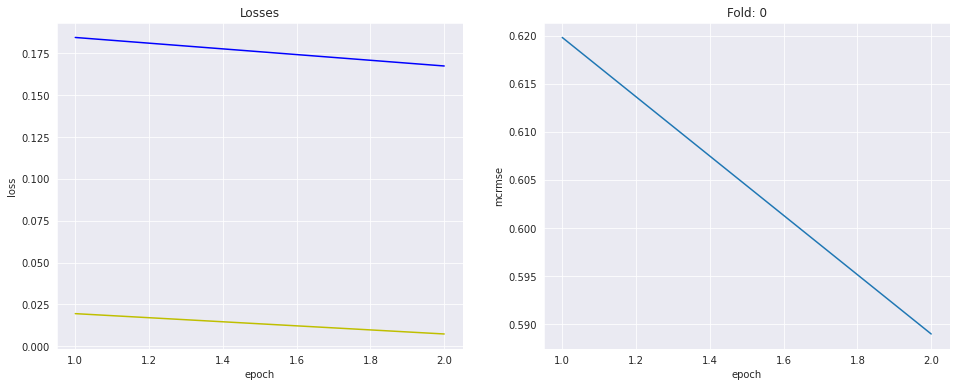

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.632437590084397
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12108 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.

---------------------------------------- Unlabelled split: 4 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.039 | Val Loss:  0.193 | Val MCRMSE:  0.634


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.010 | Val Loss:  0.178 | Val MCRMSE:  0.608


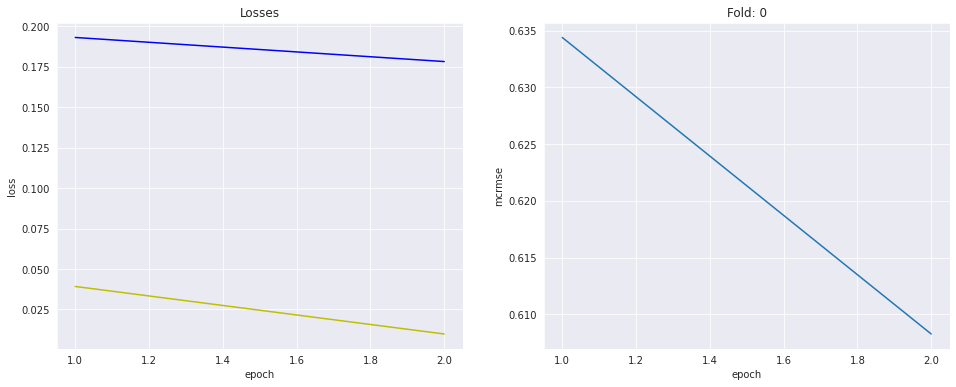

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.6534999069236193
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12108 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.
--> Traning confidence using model: {'pooling': 'max'}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T


---------------------------------------- Unlabelled split: 1 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.022 | Val Loss:  0.162 | Val MCRMSE:  0.581


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.014 | Val Loss:  0.194 | Val MCRMSE:  0.639


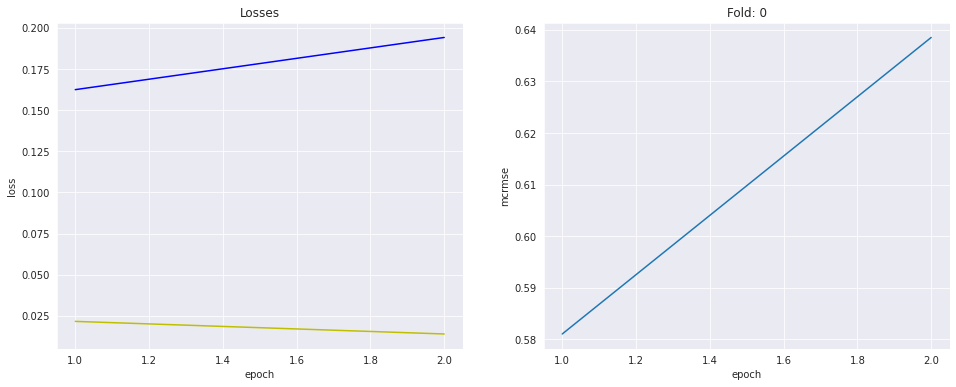

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.6843466185752675
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12106 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.

---------------------------------------- Unlabelled split: 2 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.019 | Val Loss:  0.168 | Val MCRMSE:  0.591


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.011 | Val Loss:  0.185 | Val MCRMSE:  0.622


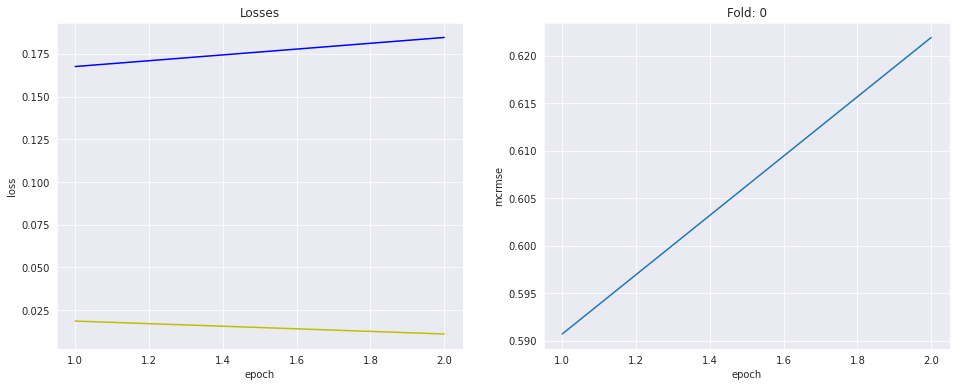

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.6662716789780418
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12106 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.

---------------------------------------- Unlabelled split: 3 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.017 | Val Loss:  0.209 | Val MCRMSE:  0.664


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.012 | Val Loss:  0.169 | Val MCRMSE:  0.593


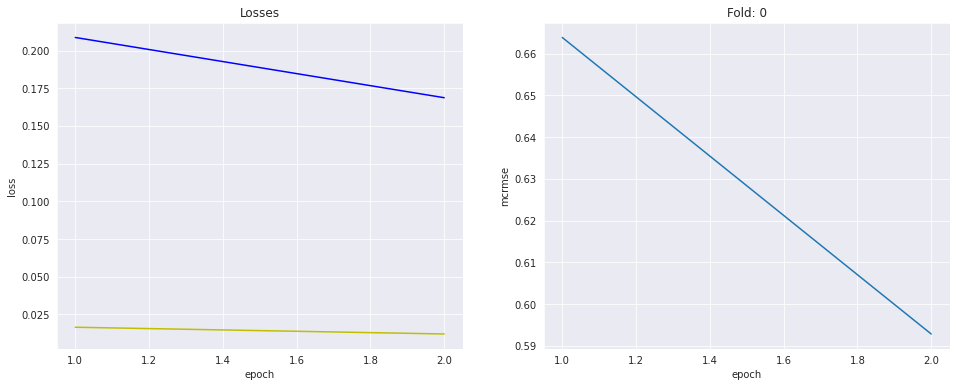

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.6351153565915636
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12106 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.

---------------------------------------- Unlabelled split: 4 ----------------------------------------


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.019 | Val Loss:  0.175 | Val MCRMSE:  0.605


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.010 | Val Loss:  0.180 | Val MCRMSE:  0.613


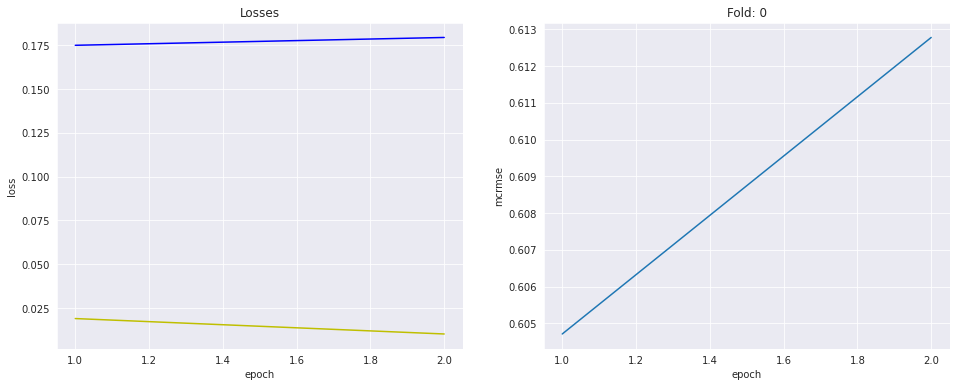

  0%|          | 0/9 [00:00<?, ?it/s]

----> MCRMSE: 0.6563909986060279
Saving model to tmp location...
Initial GPU Usage
GPU memory occupied: 12106 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1486 MB.




--> Training model on the final part of the data...


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.153 | Val Loss:  0.145 | Val MCRMSE:  0.543


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.133 | Val Loss:  0.143 | Val MCRMSE:  0.539


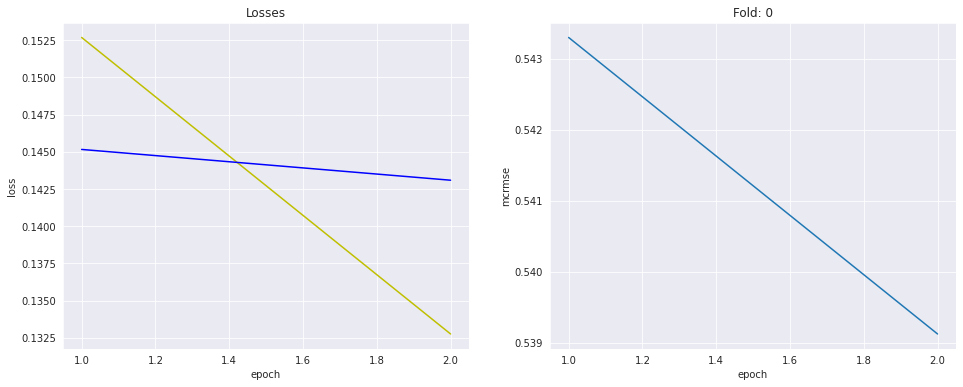

Saving model...


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.134 | Val Loss:  0.124 | Val MCRMSE:  0.499


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.124 | Val Loss:  0.127 | Val MCRMSE:  0.507


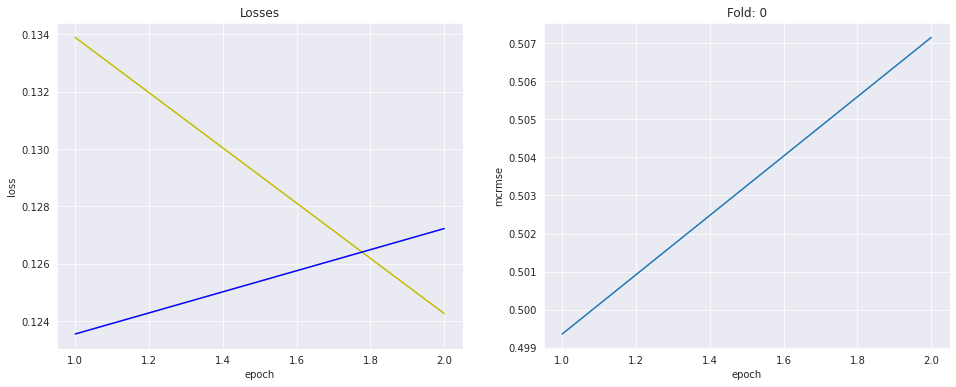

Saving model...


In [ ]:
if RETRAIN:
    print('Training model')

    Path(f'{BASIC_PATH}/models/{MODEL_NAME}').mkdir(parents=True, exist_ok=True)

    coreg_labelled_data = train_coreg(val_split_20, aug_data, test_split, config=config, plot=True)
    
    with open(f'{BASIC_PATH}/models/{MODEL_NAME}/trained', 'w') as f:
        f.write(str(datetime.now()))

In [ ]:
free_gpu_cache()
gc.collect()

Initial GPU Usage
GPU memory occupied: 4530 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1936 MB.


129

In [ ]:
model_max = get_model(0, False, **{'pooling': 'max'})
model_mean = get_model(0, False, **{'pooling': 'mean'})
pred_max, _ = predict(model_max, test_split, {**config, 'batch_size': 2 * config['batch_size']})
pred_mean, _ = predict(model_mean, test_split, {**config, 'batch_size': 2 * config['batch_size']})

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
predictions = (pred_max + pred_mean) / 2
score = MCRMSE(y_test[TARGET_VARIABLES], predictions)
score

0.5146851441263168

In [ ]:
model_max = get_model(0, True, **{'pooling': 'max'})
model_mean = get_model(0, True, **{'pooling': 'mean'})

results = training(model_mean, coreg_labelled_data[0], test_split, config, do_val=True)
results = training(model_max, coreg_labelled_data[1], test_split, config, do_val=True)

plot_results(0, results)

pred_max, _ = predict(model_max, test_split, {**config, 'batch_size': 2 * config['batch_size']})
pred_mean, _ = predict(model_mean, test_split, {**config, 'batch_size': 2 * config['batch_size']})

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  2.423 | Val Loss:  2.089 | Val MCRMSE:  2.679


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  2.053 | Val Loss:  1.962 | Val MCRMSE:  2.555


  0%|          | 0/17 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# kfold_test_preds, kfold_test_feats = kfold_predict_features(test_split, {**config, 'batch_size': 2 * config['batch_size']})


======================================== Fold: 1 ========================================


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/1 [00:00<?, ?it/s]

Initial GPU Usage
GPU memory occupied: 2322 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2322 MB.

======================================== Fold: 2 ========================================


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/1 [00:00<?, ?it/s]

Initial GPU Usage
GPU memory occupied: 2322 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2322 MB.

======================================== Fold: 3 ========================================


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/1 [00:00<?, ?it/s]

Initial GPU Usage
GPU memory occupied: 2322 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2322 MB.

======================================== Fold: 4 ========================================


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/1 [00:00<?, ?it/s]

Initial GPU Usage
GPU memory occupied: 2322 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2322 MB.

======================================== Fold: 5 ========================================


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- T

  0%|          | 0/1 [00:00<?, ?it/s]

Initial GPU Usage
GPU memory occupied: 2322 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2322 MB.


[[array([[3.0007   , 2.9099228, 3.1322393, 3.00761  , 2.9043686, 2.9651253],
         [3.1146402, 3.0237541, 3.2338943, 3.1248307, 3.0247986, 3.0750496],
         [3.701817 , 3.618701 , 3.7611015, 3.7414477, 3.6642988, 3.6719465]],
        dtype=float32)],
 [array([[3.1260626, 3.0073352, 3.2204266, 3.1339679, 3.0271966, 3.087663 ],
         [3.1487396, 3.0276957, 3.2406855, 3.157513 , 3.0577643, 3.1250162],
         [3.5703719, 3.46253  , 3.6361446, 3.60819  , 3.5176542, 3.6115658]],
        dtype=float32)],
 [array([[2.7322044, 2.6162493, 2.900655 , 2.702633 , 2.5716808, 2.6529396],
         [2.772585 , 2.6586483, 2.934145 , 2.7450442, 2.616905 , 2.6974745],
         [3.5334632, 3.454013 , 3.5922246, 3.550627 , 3.454503 , 3.4943426]],
        dtype=float32)],
 [array([[2.7837245, 2.6553667, 2.9357793, 2.7371411, 2.63258  , 2.715329 ],
         [2.965769 , 2.8353298, 3.0791304, 2.9233177, 2.824441 , 2.9105797],
         [3.4899535, 3.3791523, 3.5199697, 3.4891999, 3.4009936, 3.4565437]

In [ ]:
score = evaluate()

In [ ]:
predictions = np.array(kfold_preds).mean(axis=0)
predictions

array([[2.891453 , 2.8090968, 3.0330267, 2.8737845, 2.845502 , 2.880161 ],
       [2.6243505, 2.5249796, 2.7598124, 2.6114604, 2.5250053, 2.5575504],
       [3.654301 , 3.6098685, 3.7626216, 3.6877012, 3.6392689, 3.6897836],
       ...,
       [3.4005582, 3.3258133, 3.5270126, 3.4028995, 3.3403044, 3.3804917],
       [3.6646526, 3.628543 , 3.7674718, 3.7053642, 3.6722927, 3.707767 ],
       [3.604351 , 3.5632355, 3.7174287, 3.6420538, 3.5880263, 3.6228907]],
      dtype=float32)

In [ ]:
preds = pd.DataFrame(predictions, columns=TARGET_VARIABLES)
preds

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,2.891453,2.809097,3.033027,2.873785,2.845502,2.880161
1,2.624351,2.524980,2.759812,2.611460,2.525005,2.557550
2,3.654301,3.609869,3.762622,3.687701,3.639269,3.689784
3,3.140994,3.043234,3.269636,3.117384,3.036477,3.077926
4,3.508729,3.428294,3.616297,3.507658,3.430756,3.487214
...,...,...,...,...,...,...
995,3.639796,3.603461,3.746722,3.692122,3.638593,3.677299
996,3.607509,3.566206,3.722152,3.645226,3.602233,3.623445
997,3.400558,3.325813,3.527013,3.402900,3.340304,3.380492
998,3.664653,3.628543,3.767472,3.705364,3.672293,3.707767


In [ ]:
preds.to_csv(f'{BASIC_PATH}/data/aug_data_pred.csv', index=False)